In [ ]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np

In [ ]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.12.0

GPU is AVAILABLE


#Preparing the data

Reading the data

In [ ]:

# path = path if os.path.exists(path) else ".{}".format(path)
# file_path = os.path.join(path, "language-translation-englishfrench", "/content/drive/MyDrive/eng_-french.csv")
file_path ='/content/eng_-french.csv'

# read the data
df = pd.read_csv(file_path)
df['source'] = df['English words/sentences']

# let's add an initial “seed” token ([start]) and a stop token ([end]) to each target sentence.
df['target'] = df['French words/sentences'].apply(lambda x: '[start] ' + x + ' [end]')
df = df.drop(['English words/sentences', 'French words/sentences'], axis=1)

# display a few random samples
df.sample(5)


,source,target
45106,Where are my trousers?,[start] Où se trouve mon pantalon ? [end]
80861,Are you looking for someone?,[start] Tu cherches quelqu'un ? [end]
112637,Will you please show me the way?,"[start] Me montreras-tu le chemin, s'il te pla..."
77323,It's none of your business.,[start] Ce ne sont pas tes affaires. [end]
126299,She assumed an air of indifference.,[start] Elle a pris un air indifférent. [end]


Shuffling the data and splitting it into train, validation, and test sets

max_tokens parameter - 
sequence lenght - 

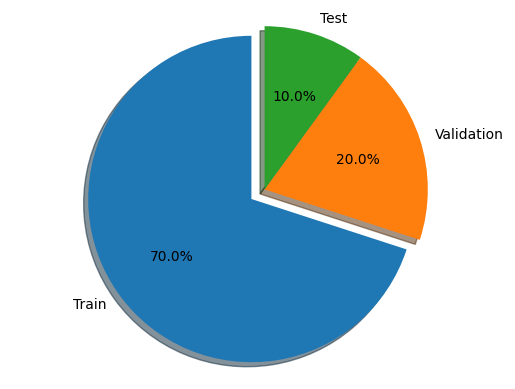

In [ ]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

Standardizing, tokenizing and indexing the data

In [ ]:
max_tokens = 25000
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)
# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [ ]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)
target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): It's very clean.
Target texts (one random sample): [start] C'est très propre. [end]
Source vectors (one random sample): tf.Tensor(
[ 47  54 599   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[  2  29  53 614   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(31,), dtype=int64)
Source decoded texts (one random sample): its very clean                            
Target decoded texts (one random sample): [start] cest très propre [end]                           


In [ ]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (122934, 30)
Target vectors (shape): (122934, 31)


#Building Transformer
Positional Embedding

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) 
        # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [ ]:
# display a random sample before and after embbeding just to test our class

embed_dim = 256
train_source_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="source_embedding",
) (train_source_vectors)

train_target_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="target_embedding",
) (train_source_vectors)

random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
print("Source embedded vectors (one random sample):", train_source_embedded[random_sample])
print("Target embedded vectors (one random sample):", train_target_embedded[random_sample])

Source texts (one random sample): Is the school on this side of the river?
Target texts (one random sample): [start] Est-ce que l'école est de ce côté de la rivière ? [end]
Source vectors (one random sample): tf.Tensor(
[  7   5 161  33  14 785  12   5 680   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2   81    7  217   15    5   17  473    5   10 7193    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source embedded vectors (one random sample): tf.Tensor(
[[-0.03575045  0.00688008 -0.05422808 ... -0.09192665 -0.05659594
  -0.02424612]
 [ 0.05053169  0.03264599 -0.0571413  ... -0.00876415  0.00909493
  -0.09554061]
 [-0.00118278  0.02178463  0.01152462 ...  0.02620129  0.0029407
  -0.05680144]
 ...
 [ 0.0136307   0.03146141  0.01165657 ... -0.05878459 -0.05308883
   0.00865269]
 [ 0.04181018

In [ ]:
# display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (122934, 30, 256)
Target embedded vectors (shape): (122934, 30, 256)


**The Attention mechanism**

Causal Masking

In [ ]:
# credits to OpenAI for that one (https://github.com/openai/gpt-2/blob/master/src/model.py)

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)
def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [ ]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 3.5926497e-01 -1.0000000e+10 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 1.0210156e-02  4.6676528e-01 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 4.6962190e-01  7.4541569e-03  5.0332975e-01 -1.0000000e+10
    -1.0000000e+10]
   [ 5.2242863e-01  9.3802702e-01  2.2934878e-01  6.6834188e-01
    -1.0000000e+10]
   [ 8.6922121e-01  8.5046291e-02  3.9657211e-01  9.4453347e-01
     2.1551991e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


Scaled Dot-Product Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [ ]:
# display the shape of our attention output just to test the function
input = train_source_embedded
input = tf.expand_dims(input, axis=1)
print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (122934, 1, 30, 256)


Multi-Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = tf.keras.layers.Dense(embed_dim)
        self.k_linear = tf.keras.layers.Dense(embed_dim)
        self.v_linear = tf.keras.layers.Dense(embed_dim)
        self.concat_linear = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

**The Encoder**

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

**The Decoder**

In [ ]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.layer_norm_3 = tf.keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

**Putting it all together**

In [ ]:
batch_size = 64

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [ ]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (64, 30)
Decoder Inputs: (64, 30)
Decoder Outputs: (64, 30)


In [ ]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# the transformer body
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# the transformer head
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

#Training the Transformer

Let's translate a few random test sentences with our newly-trained Transformer.



In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/50
1921/1921 [==============================] - 268s 132ms/step - loss: 0.9549 - accuracy: 0.8574 - val_loss: 0.6031 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 2/50
1921/1921 [==============================] - 237s 123ms/step - loss: 0.5689 - accuracy: 0.9024 - val_loss: 0.4909 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 3/50
1921/1921 [==============================] - 238s 124ms/step - loss: 0.4706 - accuracy: 0.9141 - val_loss: 0.4624 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 4/50
1203/1921 [=================>............] - ETA: 1:16 - loss: 0.4211 - accuracy: 0.9204

# Testing the Transformer

In [ ]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()